HELLO THIS IS MY REFERENCE : building llm from scratch book by sebastian

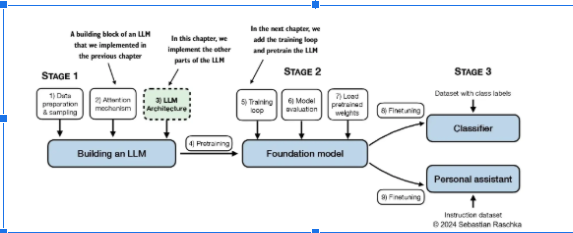

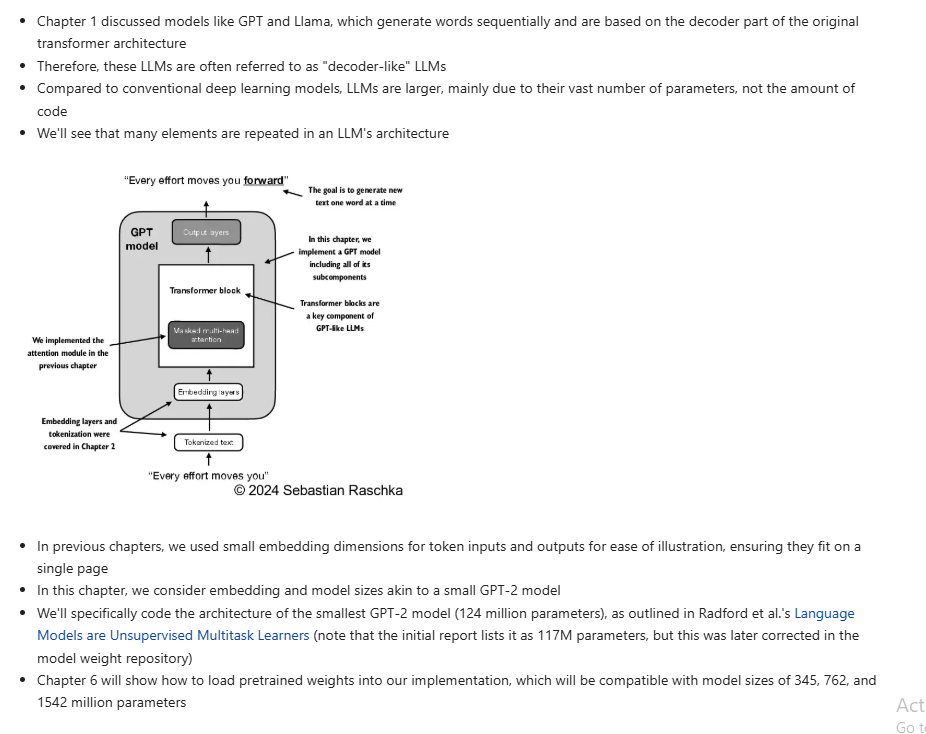

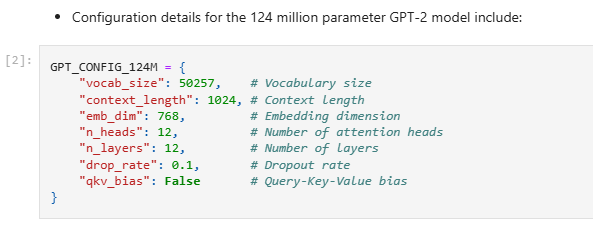

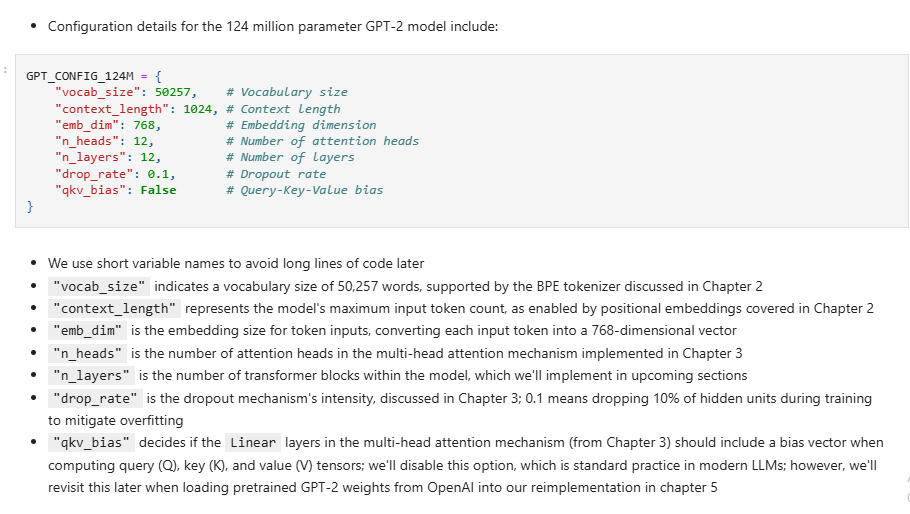

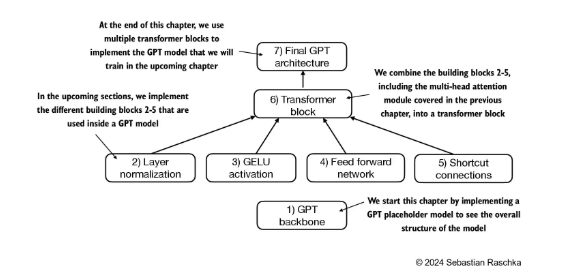

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

** MY aproach : before building the orginal gpt i want  to build dummy GPT which will tell me how the structure should look like **

In [ ]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self , cfg ):
    super().__init__()

    # normally the flow is like :
    #     1 token embedding + pos emebdding
    #     2 tranformer blocks
    #     3 norm and out

    # nn.embedding args are  no of elemnets , dim of emebed you want
    self.tok_emb = nn.Embedding(cfg["vocab_size"] , cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"] , cfg["emb_dim"])

    # nn.dropout ars is amount of dropout you want 0 to 1
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    # not *[] is unpacking list
    # nn.Sequential is like adding all the blocks sequentially

    self.trf_blocks = nn.Sequential(
        *[ DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_heads = nn.Linear(cfg["emb_dim"]  , cfg["vocab_size"] , bias = False )

  def forward(self , in_idx):
    #  first we will ket the tokenized inputs
    # ->  we will conver the input tokens to embedings using the self.toke_emb
    # ->  we will add the pos_emb for
    # -> we will send this to the trf_blocks
    # -> then we apply the layer_norm
    # -> then we will apply the linear projection

    batch_size  , seq_len = in_idx.shape
    # see here context length is like max no of tokens we can have
    # seq length is the length of tokens in the input
    #  seqlen <= contxt length if seq len < contxt we will make it equal to
    # contxt len using the padding

    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len , device = in_idx.device) )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_heads(x)
    return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x



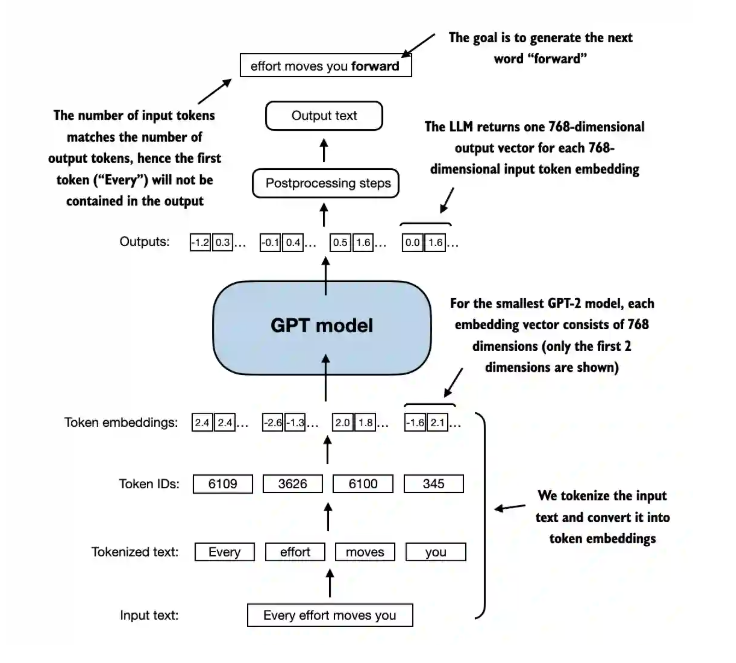

** important thing to remebr is if we send the batch x seqlen  we will get batch * seq lenth here whats the imp thing is is to predict the next token .
if se len is 4 and input is " every effort moves you -> then out put is effort moves you forward .<br>
if every pad pad pad is only input -> every effort pad pad  **

In [ ]:
# input we will send the tokens using the ticktoken

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


**Now lets start building the blocks **

1) Layer normalization .
layer normalization helps in reducing the :
1) problem of vanishing gradient , exploding gradint .( if gradient is low then update in the elemts is low and if the gradient is too high then update in the elemnts is also too high ) so this can be reduced using the normalization .
2) internal covariate shift : which means that the distribution of the parmaters might change for every different input so what we do is if we make always the inpu the mean 0 and var 1 . then the curve or distribution will not change much .

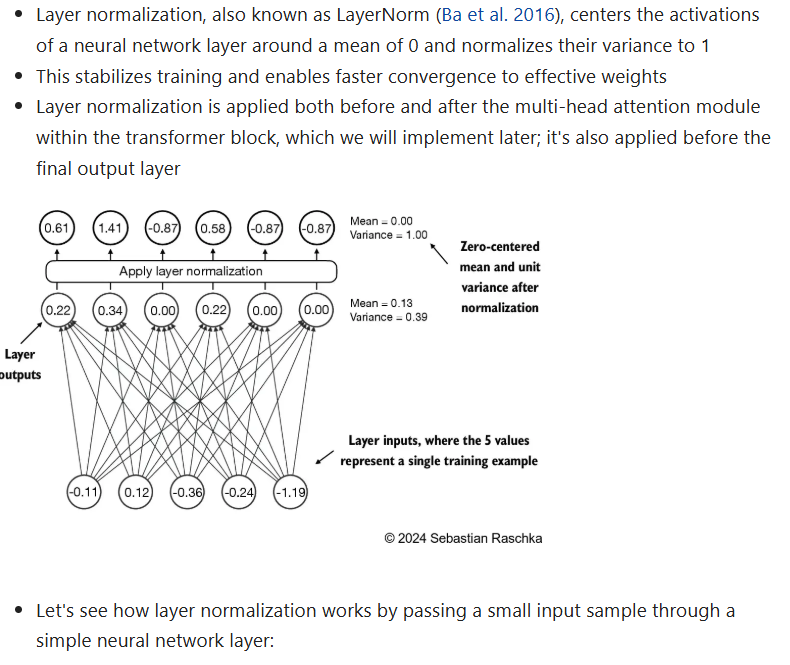

In [ ]:
import torch
import torch.nn as nn
torch.manual_seed(123)

exp = torch.randn(2 , 5)

layer = nn.Sequential( nn.Linear(5 , 6) , nn.ReLU() )
out = layer(exp)

print(out)


tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
mean = out.mean(dim = -1 , keepdim = True )
var = out.var(dim = -1 , keepdim = True )
print("Mean : \n" , mean )
print("Variance : \n  " , var )

Mean : 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance : 
   tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


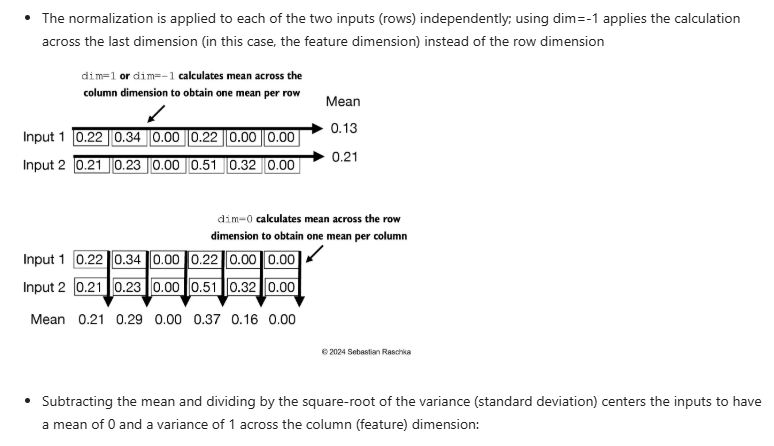

In [ ]:
# lets normalize the above
out_norm = (out - mean)/torch.sqrt(var)

new_mean = out_norm.mean(dim = -1  , keepdim = True )
new_var = out_norm.var(dim = -1  , keepdim = True )
print(out_norm)
print(new_mean)
print(new_var)


tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<center> **ACTUAL LAYER NORM CLASS : ** </center>

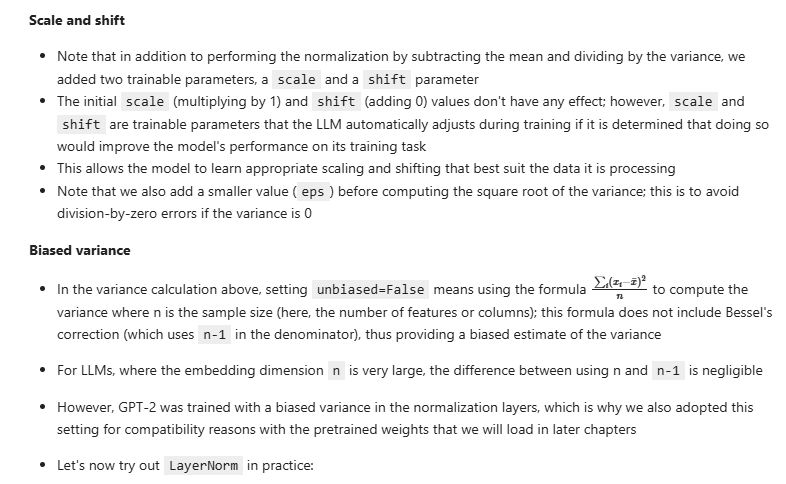

<div class="alert alert-block alert-warning">

This specific implementation of layer Normalization operates on the last dimension of the
input tensor x, which represents the embedding dimension (emb_dim).

The variable eps is a
small constant (epsilon) added to the variance to prevent division by zero during
normalization.

The scale and shift are two trainable parameters (of the same dimension
as the input) that the LLM automatically adjusts during training if it is determined that
doing so would improve the model's performance on its training task.

This allows the model
to learn appropriate scaling and shifting that best suit the data it is processing.

</div>

_A small note on biased variance_

<div class="alert alert-block alert-info">

In our variance calculation method, we have opted for an implementation detail by
setting unbiased=False.

For those curious about what this means, in the variance
calculation, we divide by the number of inputs n in the variance formula.

This approach does not apply Bessel's correction, which typically uses n-1 instead of n in
the denominator to adjust for bias in sample variance estimation.

This decision results in a so-called biased estimate of the variance.

For large-scale language
models (LLMs), where the embedding dimension n is significantly large, the
difference between using n and n-1 is practically negligible.

We chose this approach to ensure compatibility with the GPT-2 model's normalization layers and because it
reflects TensorFlow's default behavior, which was used to implement the original GPT2 model.
</div>

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self , emb_dim):
     super().__init__()
     self.eps = 1e-5
    #  this is for making shure of denomi is not 0
     self.scale = nn.Parameter(torch.ones(emb_dim))
     self.shift = nn.Parameter(torch.zeros(emb_dim))
    #  scale and shift we are adding to bring the learning parameters

  def forward(self , x):
    mean = x.mean(dim = -1 , keepdim = True )
    var = x.var(dim = -1 , keepdim = True , unbiased = False )
    norm_x = (x - mean)/torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift






In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(exp)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<center>2 FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION  </center>

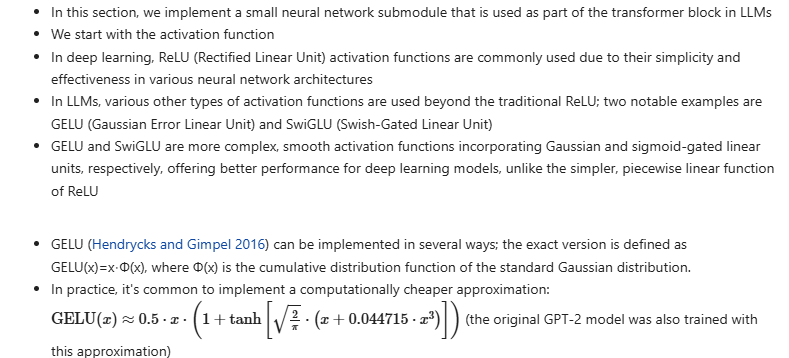

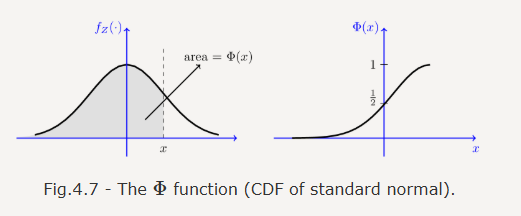

In [ ]:
# this is gelu which is used in the chat gpt and i cop[ied it from there ]
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

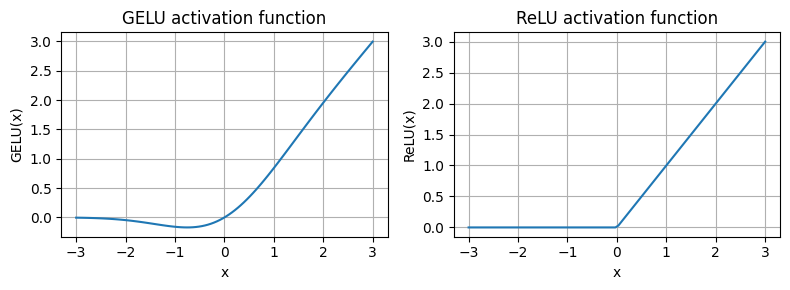

In [ ]:
# this shows how the relu different from gelu
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

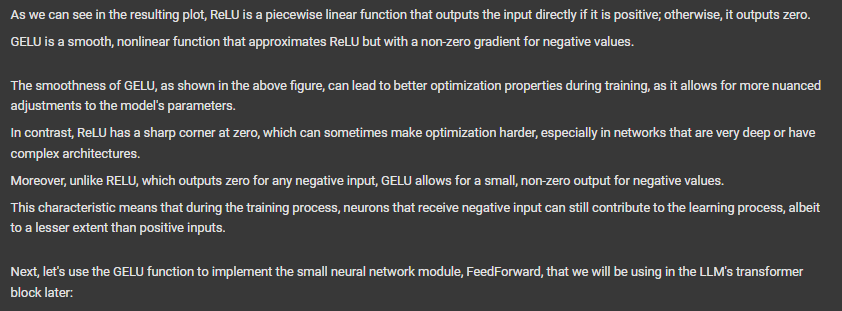

In [ ]:
class FeedForward(nn.Module):
  def __init__(self , cfg ):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"] , 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"] , cfg["emb_dim"] ),

    )

  def forward(self , x ):
    return self.layers(x)



In [ ]:
print(GPT_CONFIG_124M["emb_dim"])

768


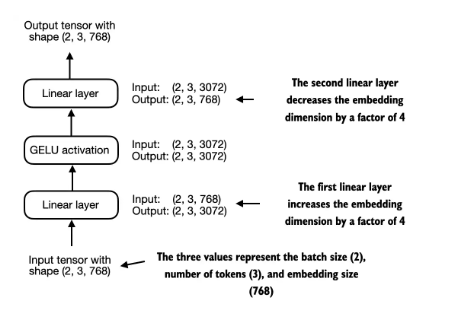

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
inp = torch.randn(2 , 3 , 768)
out = ffn(inp)
print(out.shape)

torch.Size([2, 3, 768])


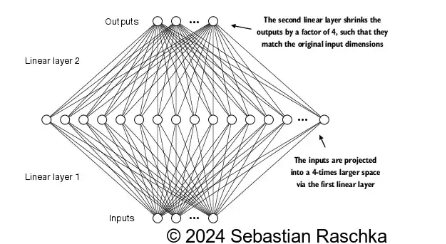

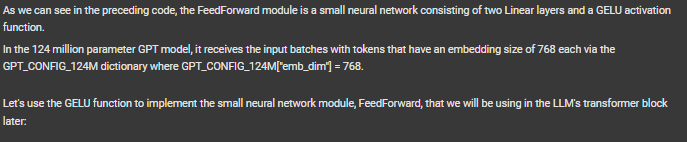

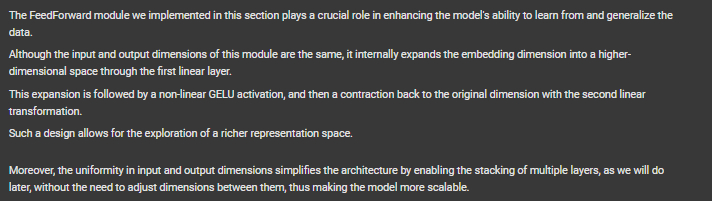

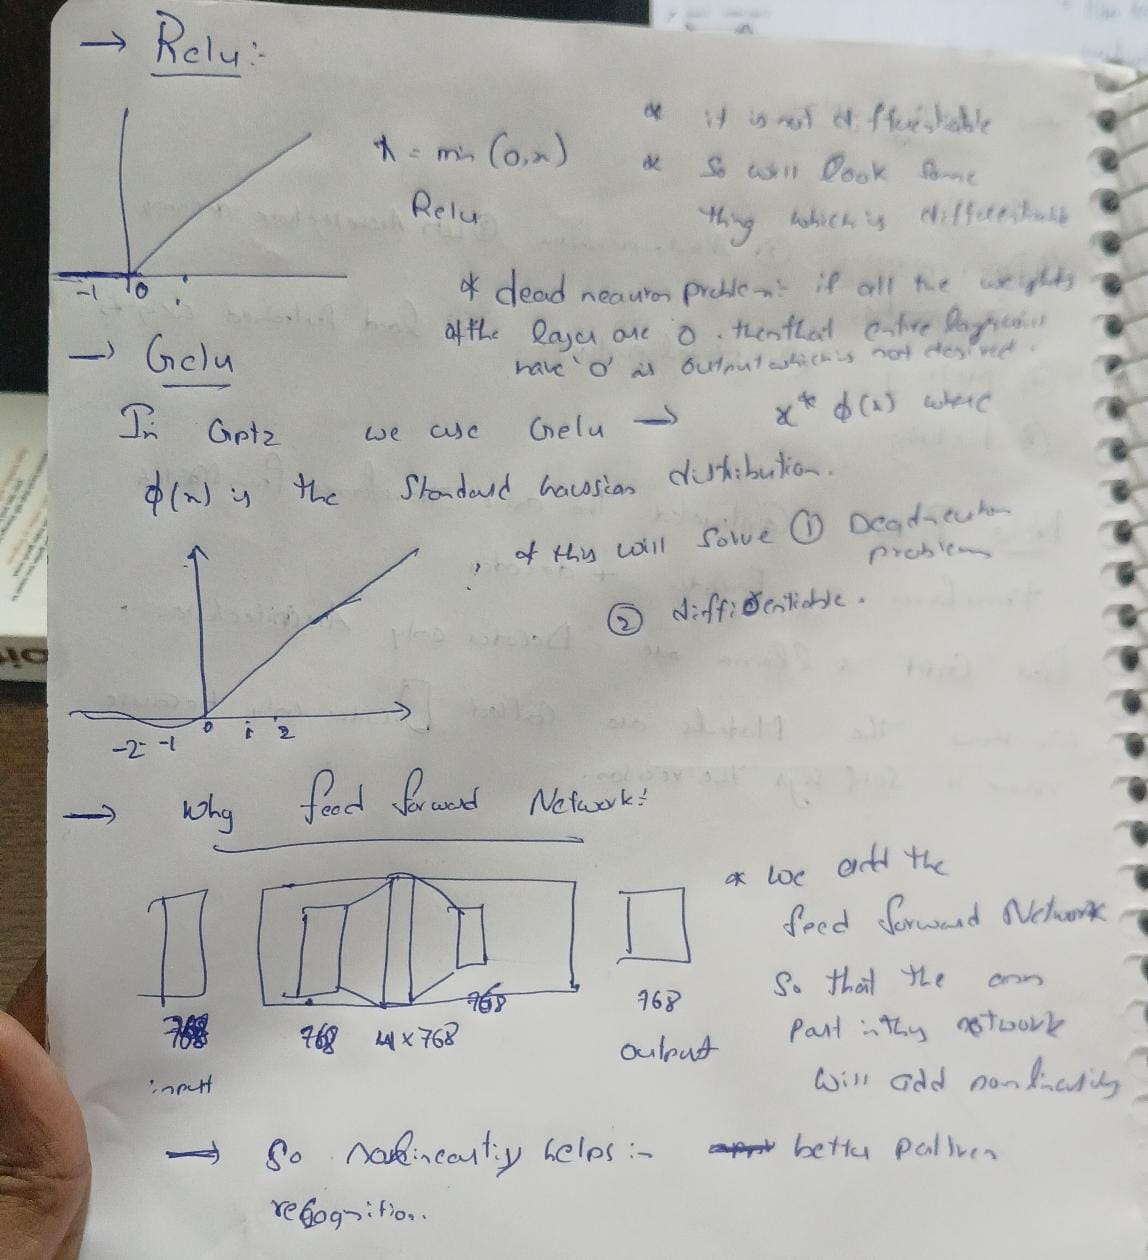

### <center>  now i am going to build the shortcut connection and explain the importance of the shortcut connection </center>

## see how the shortcut connection can bring the difference

## we will build an ann and will make tje gradient calcutaion via with shortcut and without shortcut . here i ahve taken 5 layerd ann.

In [ ]:
class ExampleDNN(nn.Module):
  def __init__(self , layer_sizes , use_shortcut ):
    super().__init__()
    self.layers = nn.ModuleList(
        [nn.Sequential( nn.Linear(layer_sizes[i] , layer_sizes[i+1]) , GELU()) for i in range(len(layer_sizes) -1 )]
    )
    self.use_shortcut = use_shortcut

  def forward(self , x):
    for layer in self.layers:
      # compute the output of the current layer
      layer_output = layer(x)
      # check if useshortcut is true or not if true add the output with input
      if self.use_shortcut and x.shape == layer_output.shape :
        x = x + layer_output
      else:
        x = layer_output
    return x


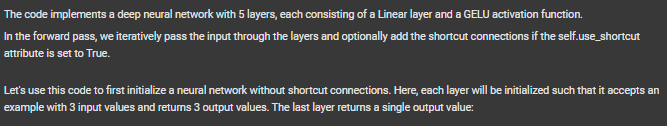

In [ ]:
# now will write a function for caluclation of the gradient in each layer
def print_gradients(model , x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss_func = nn.MSELoss()
  loss = loss_func(output , target)

  loss.backward()
  all_grads = []
  print(loss)
  for name , param in model.named_parameters():
    if 'weight' in name :
      # print the mean absolute gradient of the weights
      print(f" the type of params is {type(param)}")
      print(f"the length of params is {param.shape}")
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
      print("---" * 50)
      all_grads.append(param.grad.abs().mean().item())

  return all_grads



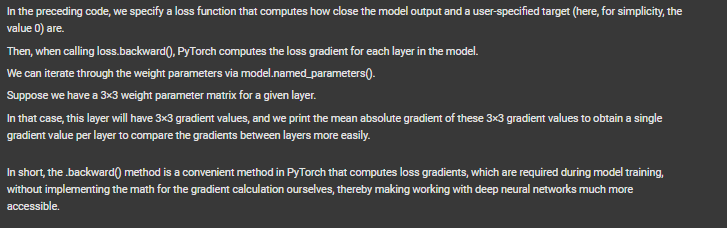

In [ ]:
# with out shortcut connection :
layer_sizes = [ 3 , 3, 3 ,3, 3,1 ]
inp = torch.tensor([[1., 0. , -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDNN( layer_sizes = layer_sizes  , use_shortcut = False )


In [ ]:
without = print_gradients(model_without_shortcut , inp )

tensor(0.0037, grad_fn=<MseLossBackward0>)
 the type of params is <class 'torch.nn.parameter.Parameter'>
the length of params is torch.Size([3, 3])
layers.0.0.weight has gradient mean of 0.00020173584925942123
------------------------------------------------------------------------------------------------------------------------------------------------------
 the type of params is <class 'torch.nn.parameter.Parameter'>
the length of params is torch.Size([3, 3])
layers.1.0.weight has gradient mean of 0.00012011159560643137
------------------------------------------------------------------------------------------------------------------------------------------------------
 the type of params is <class 'torch.nn.parameter.Parameter'>
the length of params is torch.Size([3, 3])
layers.2.0.weight has gradient mean of 0.0007152040489017963
------------------------------------------------------------------------------------------------------------------------------------------------------
 the

In [ ]:
print(without)

[0.00020173584925942123, 0.00012011159560643137, 0.0007152040489017963, 0.0013988736318424344, 0.005049645435065031]


In [ ]:
# with shortcut connections lets see
torch.manual_seed(123)
model_with_shortcut = ExampleDNN(
layer_sizes, use_shortcut=True
)
with_sm = print_gradients(model_with_shortcut, inp)

tensor(0.5882, grad_fn=<MseLossBackward0>)
 the type of params is <class 'torch.nn.parameter.Parameter'>
the length of params is torch.Size([3, 3])
layers.0.0.weight has gradient mean of 0.22169792652130127
------------------------------------------------------------------------------------------------------------------------------------------------------
 the type of params is <class 'torch.nn.parameter.Parameter'>
the length of params is torch.Size([3, 3])
layers.1.0.weight has gradient mean of 0.20694108307361603
------------------------------------------------------------------------------------------------------------------------------------------------------
 the type of params is <class 'torch.nn.parameter.Parameter'>
the length of params is torch.Size([3, 3])
layers.2.0.weight has gradient mean of 0.3289699852466583
------------------------------------------------------------------------------------------------------------------------------------------------------
 the type of 

In [ ]:
print(with_sm)

[0.22169792652130127, 0.20694108307361603, 0.3289699852466583, 0.2665732204914093, 1.3258541822433472]


In [ ]:
# now lets compare the gradients in with shortcut connection and with out shortcut connections
for ind , (val1, val2) in enumerate( zip(without, with_sm)):
    print(f"Value from gradient in layer {ind+1} \n without : {val1}   and  with shortcut connection : {val2}")
    print("--" *3)

Value from gradient in layer 1 
 without : 0.00020173584925942123   and  with shortcut connection : 0.22169792652130127
------
Value from gradient in layer 2 
 without : 0.00012011159560643137   and  with shortcut connection : 0.20694108307361603
------
Value from gradient in layer 3 
 without : 0.0007152040489017963   and  with shortcut connection : 0.3289699852466583
------
Value from gradient in layer 4 
 without : 0.0013988736318424344   and  with shortcut connection : 0.2665732204914093
------
Value from gradient in layer 5 
 without : 0.005049645435065031   and  with shortcut connection : 1.3258541822433472
------


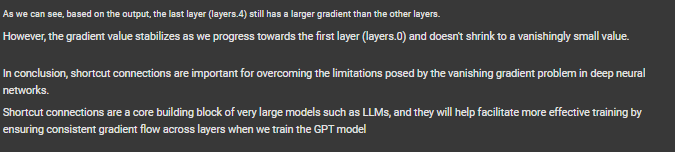

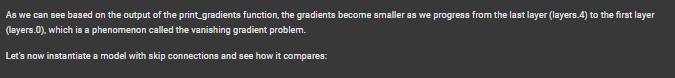

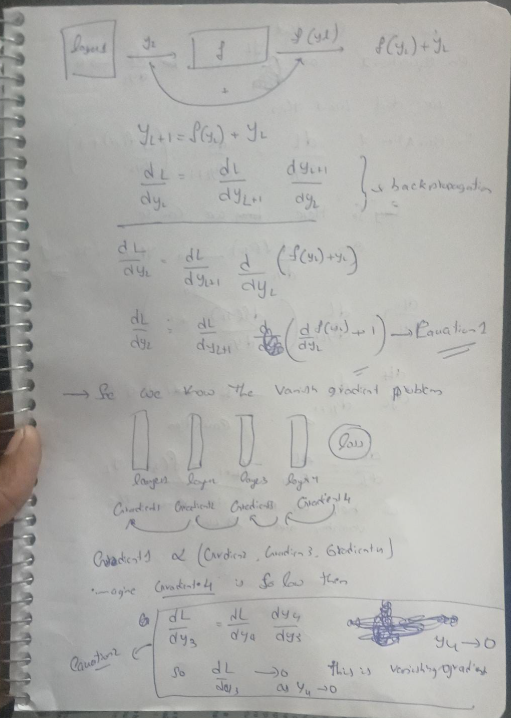

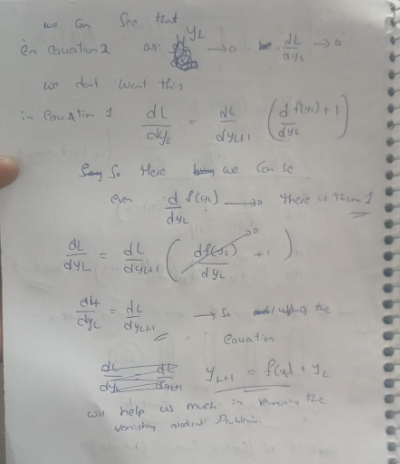

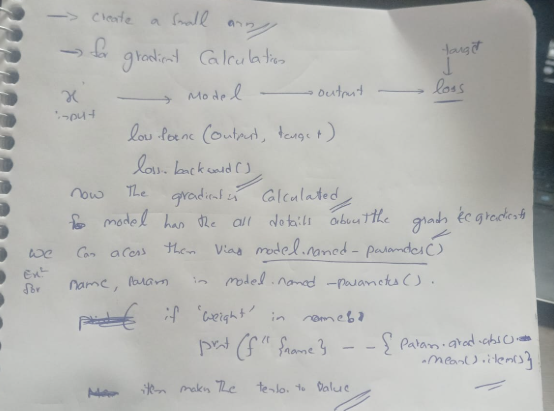

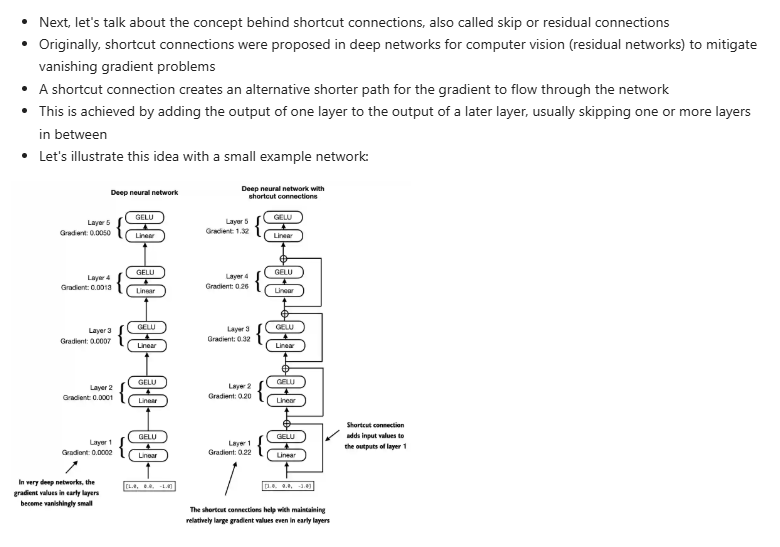

## this is attention and i wrote a detailed attention in the github in another file

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

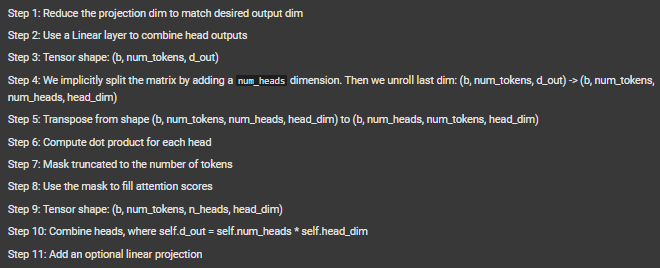

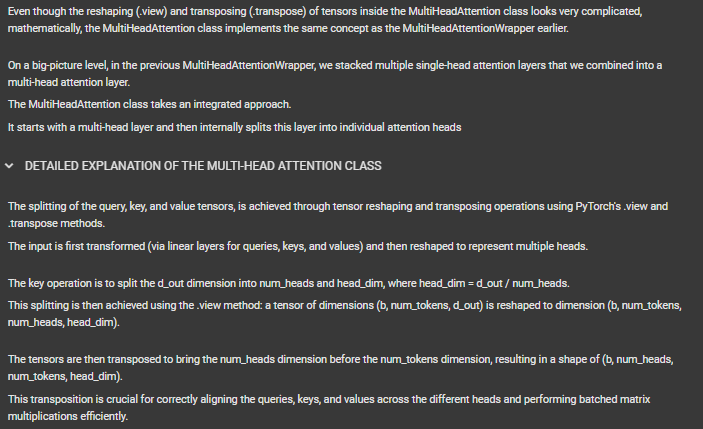

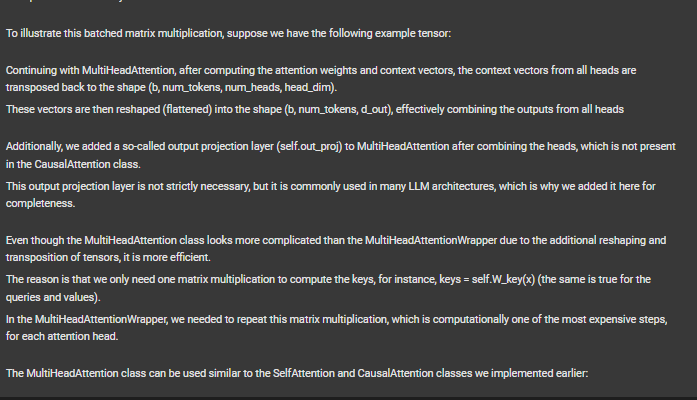

## GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

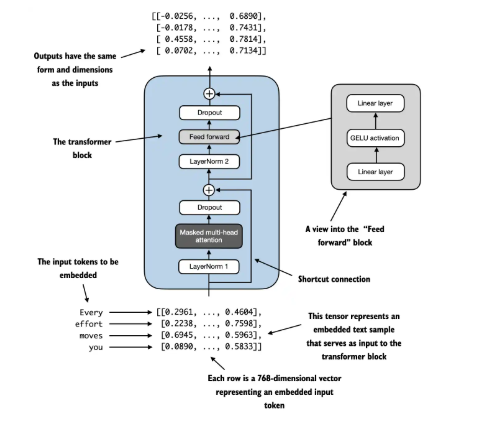

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self , cfg ):
    # from the above diagram we cansee what we want
    # 1) layer norm -> multihead -> shortcut
    # 2) layernorm -> feedforward -> shortcut
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x





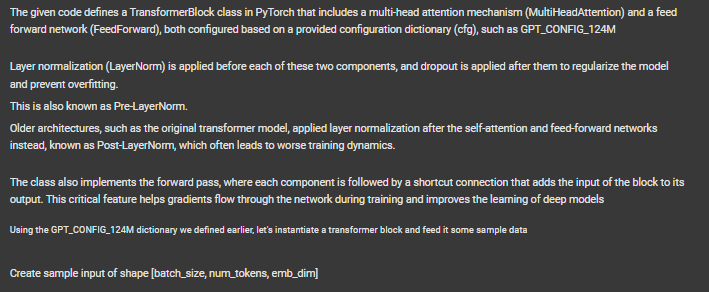

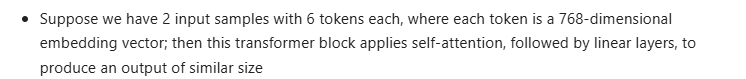

In [ ]:
torch.manual_seed(123)
inp = torch.randn(2 , 6 , 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(inp)

print(f"inp shape {inp.shape}")
print(f"out shape {out.shape}")


inp shape torch.Size([2, 6, 768])
out shape torch.Size([2, 6, 768])


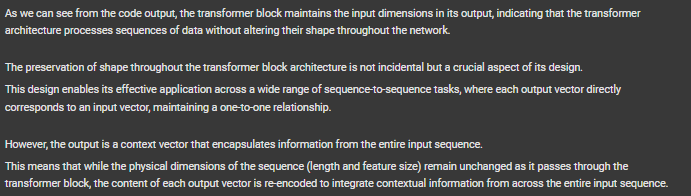

## GPT ARCHITECTURE: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

## tokenized_input -> token_embed -> pos_embed -> transformerblock -> final norm -> out head <br> these are the things that happen  

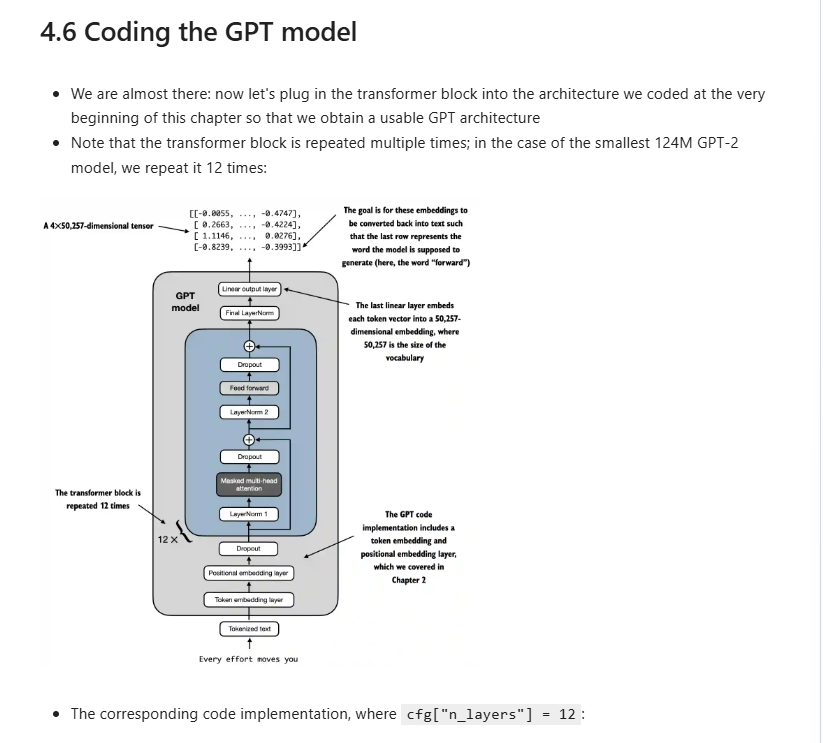

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"] , cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"] , cfg["emb_dim"] )
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        * [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"] , cfg["vocab_size"] , bias = False
    )

  def forward(self , in_idx):
    batch_size  , seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len  , device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits




In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
inp = torch.tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
out = model(inp)


In [ ]:
print(out.shape)

torch.Size([2, 4, 50257])


In [ ]:
print(out)

tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


## if some asked about the weights we can use the below code to display them

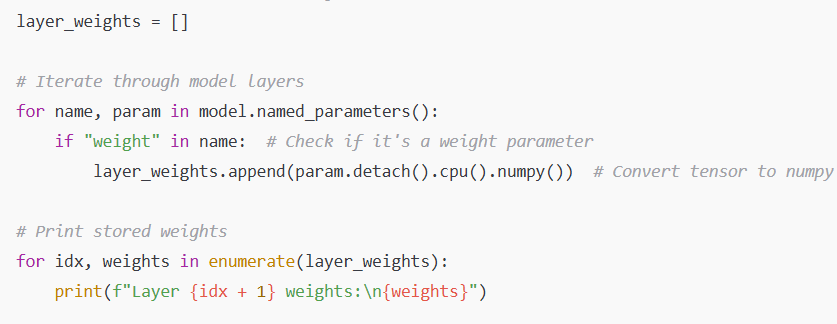

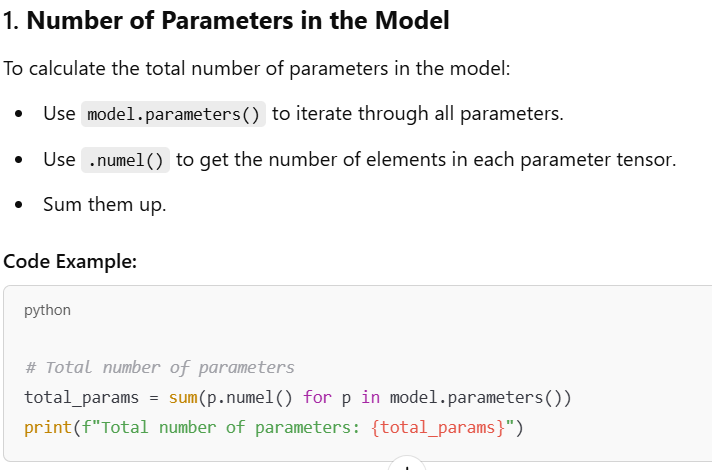

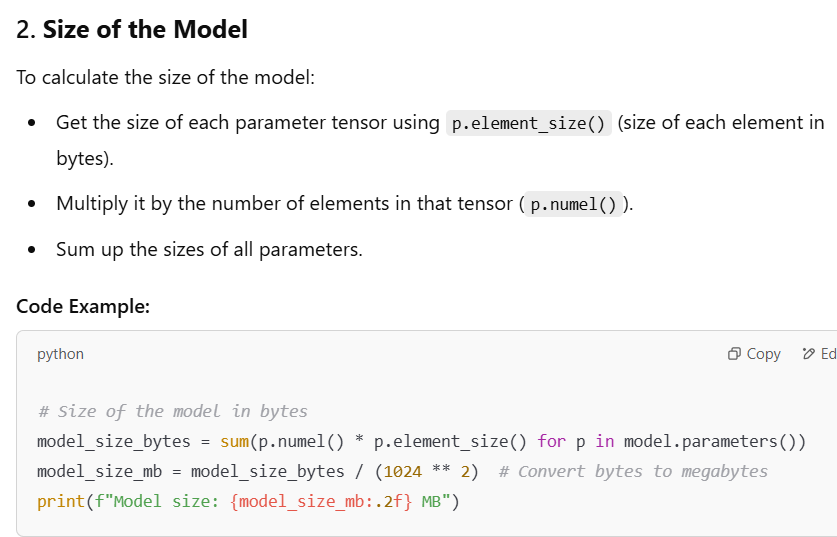

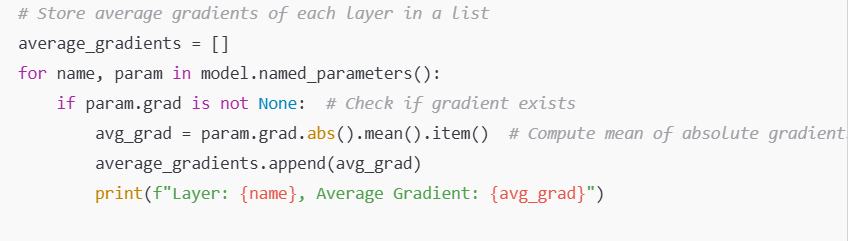

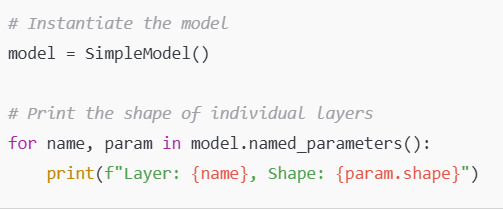

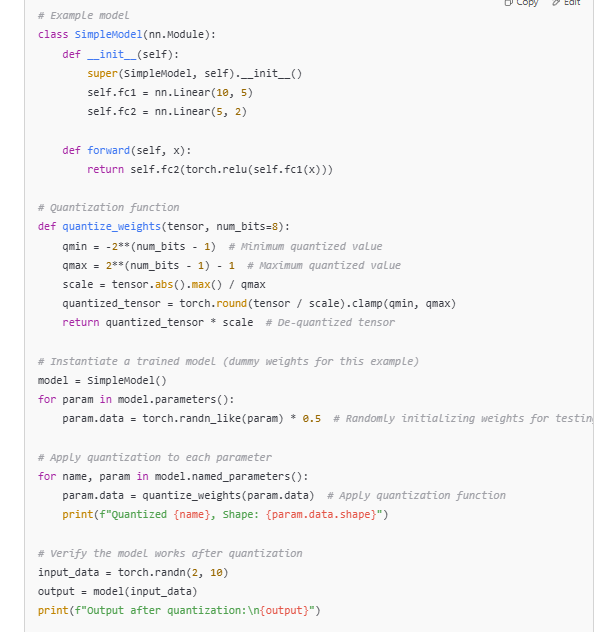

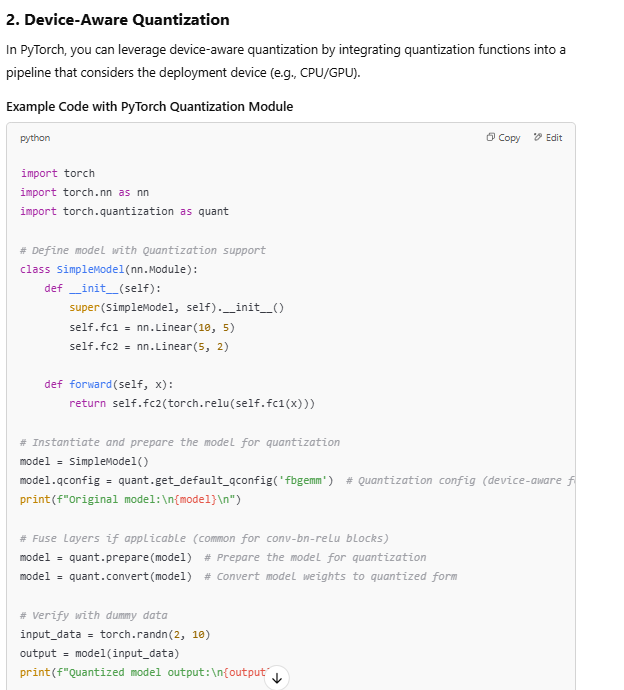

## SEE THIS IS THE CODE FOR THE QUANTIZATION AWARE TRAINING : VVIP FOR APPLYING

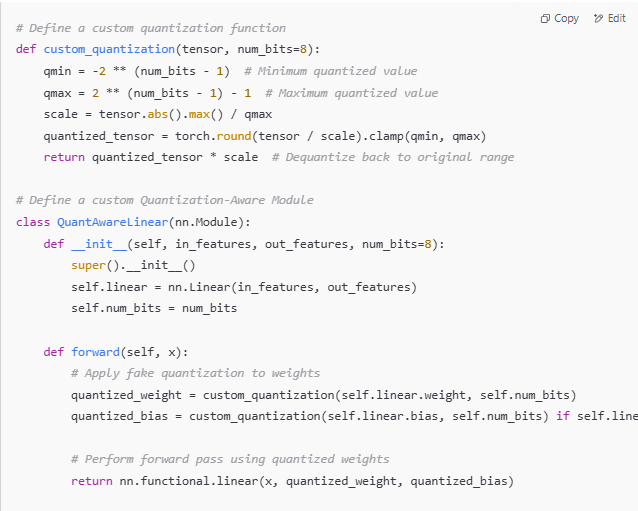

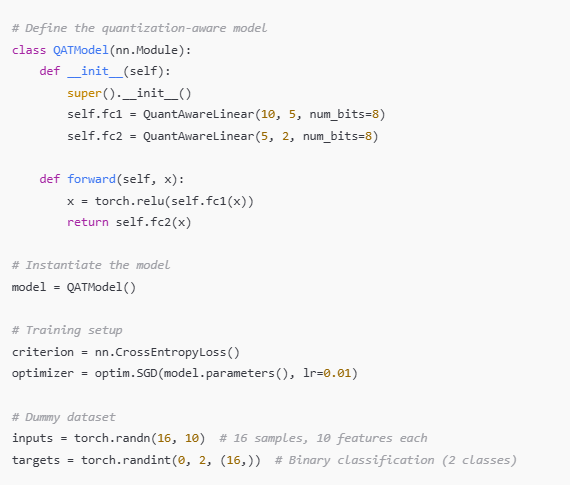

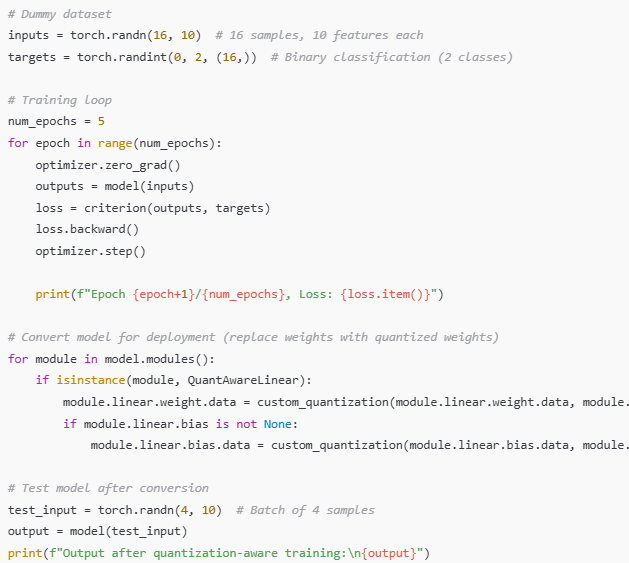

# its not used now but it can be used later

## no of parameters of the model

In [ ]:
total_params = sum( p.numel() for p in model.parameters())
print(f" totlal parameters in the model : {total_params}")

 totlal parameters in the model : 163009536


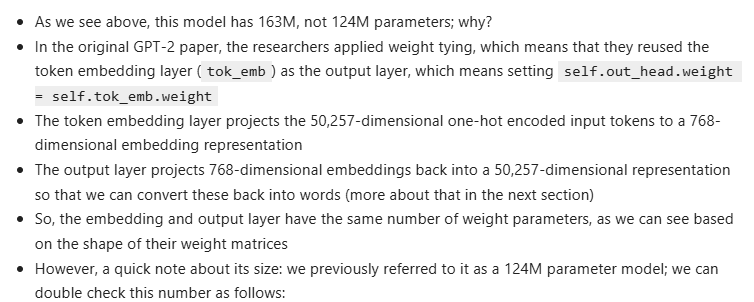

In [ ]:
print(f"token embedding layer shape : {model.tok_emb.weight.shape}")
print(f"output layer shape : {model.out_head.weight.shape}")


token embedding layer shape : torch.Size([50257, 768])
output layer shape : torch.Size([50257, 768])


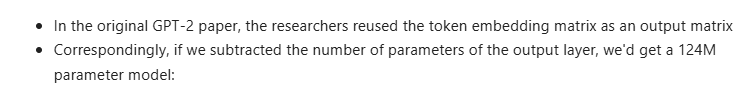

In [ ]:
# lets see the no of params if we rome the out head weghts considering that the tok emb layer weights is given to the out head layer also
new_total_params = total_params - sum( p.numel() for p in model.out_head.parameters())
print(f" the new totla params after the weight tying is {new_total_params}")

 the new totla params after the weight tying is 124412160


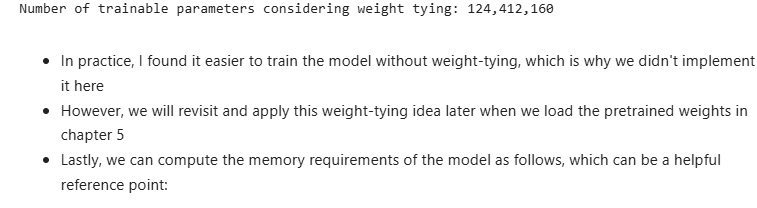

In [ ]:
model_size = sum( p.numel() * p.element_size() for p in model.parameters() )
model_size = model_size /(1024 **2)
print(f" the model size that we created is {model_size}")

 the model size that we created is 621.83203125


In [ ]:
# now lets see the model sizes of the of different gpt config

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}


def get_config(base_config, model_name="gpt2-small"):
    GPT_CONFIG = base_config.copy()

    if model_name == "gpt2-small":
        GPT_CONFIG["emb_dim"] = 768
        GPT_CONFIG["n_layers"] = 12
        GPT_CONFIG["n_heads"] = 12

    elif model_name == "gpt2-medium":
        GPT_CONFIG["emb_dim"] = 1024
        GPT_CONFIG["n_layers"] = 24
        GPT_CONFIG["n_heads"] = 16

    elif model_name == "gpt2-large":
        GPT_CONFIG["emb_dim"] = 1280
        GPT_CONFIG["n_layers"] = 36
        GPT_CONFIG["n_heads"] = 20

    elif model_name == "gpt2-xl":
        GPT_CONFIG["emb_dim"] = 1600
        GPT_CONFIG["n_layers"] = 48
        GPT_CONFIG["n_heads"] = 25

    else:
        raise ValueError(f"Incorrect model name {model_name}")

    return GPT_CONFIG

def calculate_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params:,}")

    total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
    print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

    model_size = sum( p.numel() * p.element_size() for p in model.parameters() )
    model_size = model_size /(1024 **2)
    print(f" the model size that we created is {model_size}")

In [ ]:
# models_list = [ "gpt2-small" , "gpt2-medium" , "gpt2-large" , "gpt2-xl"]

# for gpt in models_list :
#   cfg = get_config(GPT_CONFIG_124M , gpt )
#   print(f" name of the model is {gpt}")
#   model = GPTModel(cfg)
#   calculate_model_size(model)
#   print("---"*50)



 name of the model is gpt2-small
Total number of parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160
 the model size that we created is 621.83203125
------------------------------------------------------------------------------------------------------------------------------------------------------
 name of the model is gpt2-medium
Total number of parameters: 406,212,608
Number of trainable parameters considering weight tying: 354,749,440
 the model size that we created is 1549.578125
------------------------------------------------------------------------------------------------------------------------------------------------------
 name of the model is gpt2-large
Total number of parameters: 838,220,800
Number of trainable parameters considering weight tying: 773,891,840
 the model size that we created is 3197.55859375
-------------------------------------------------------------------------------------------------------------------------------

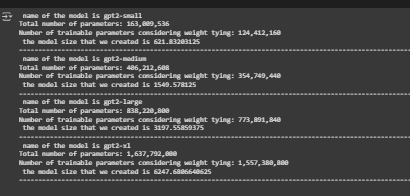

## GPT ARCHITECTURE : GENERATING TEXT FROM OUTPUT TOKENS


<div class="alert alert-block alert-info">

Step 1: idx is a (batch, n_tokens) array of indices in the current context

Step 2: Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
context size is 10 then only the last 5 tokens are used as context

Step 3: Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

Step 4: probas has shape (batch, vocab_size)

Step 5: idx_next has shape (batch, 1)

Step 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

</div>

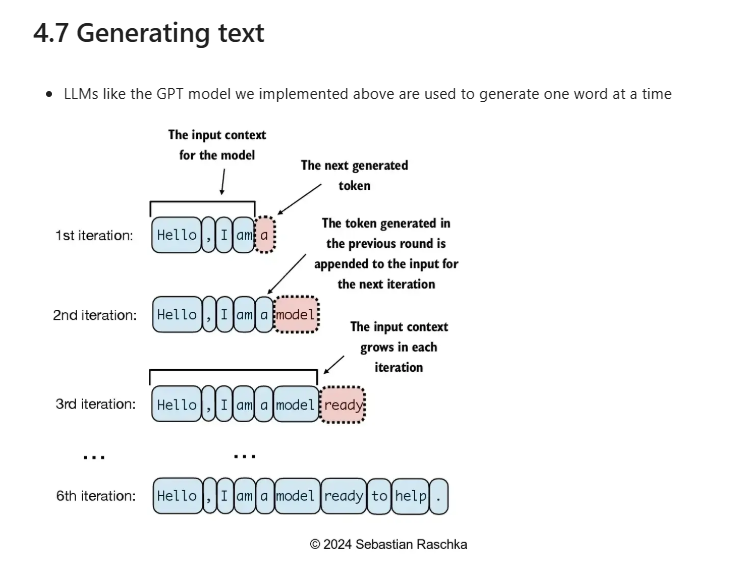

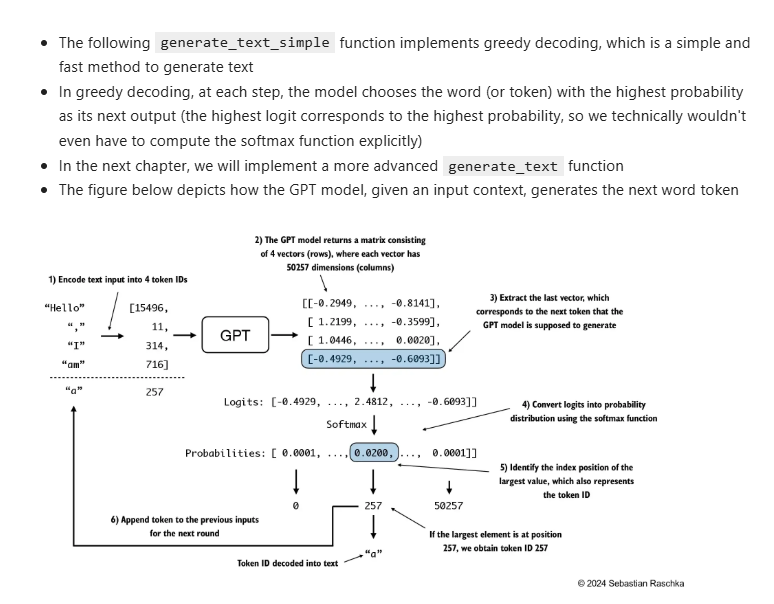

In [ ]:
def generate_text_simple(model , idx , max_mew_tokens , context_size ):
  # input is like ( batch , seq_len) ie indexs
  for _ in range(max_new_tokens):
    # might be the indexs are more in num than model capacity so lets take last indx
    idx_cond = idx[ : , -context_size : ]
    # now lets give it to the model and get the logits
    with torch.no_grad():
      logits = model(idx_cond)

    # we have the (batch , seq_len , vocabsize )


    # we only need the last row as our task is to predict the next token

    logits = logits[ : , -1 , :]
    # it is like saying give me all batches last row with all cols
    # we will get the (btach , vocabsize)

    # now lets apply the softmax so that we will get the get the things in probability terms
    probas = torch.softmax(logits , dim = -1 )

    # now we need the ind of the one with max prob
    idx_next = torch.argmax(probas , dim = -1 , keepdim = True )

    # now lets concat the predicted token with the idx

    idx = torch.cat((idx , idx_next) , dim = 1 )
    # (batch , nooftok +1 )

  return idx


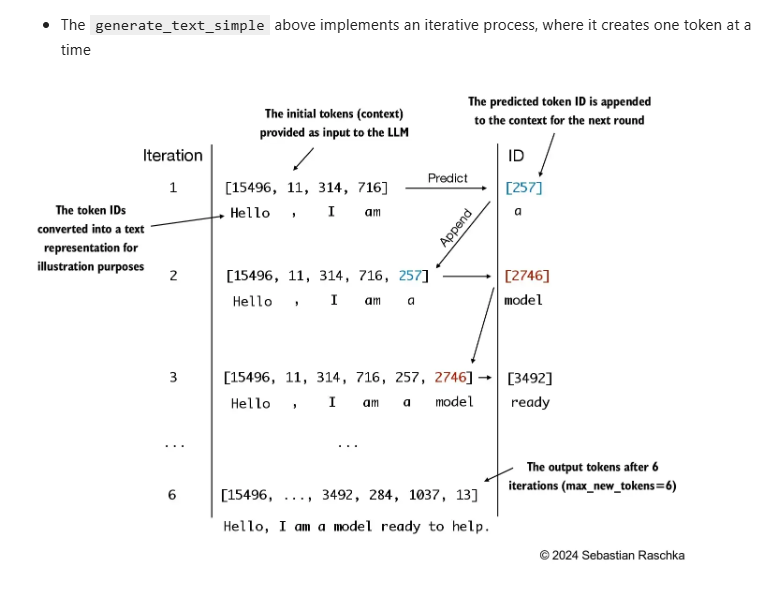

<div class="alert alert-block alert-warning">
    
In the preceeding code, the generate_text_simple function, we use a softmax function to
convert the logits into a probability distribution from which we identify the position with the
highest value via torch.argmax.

The softmax function is monotonic, meaning it preserves
the order of its inputs when transformed into outputs.

So, in practice, the softmax step is
redundant since the position with the highest score in the softmax output tensor is the
same position in the logit tensor.

In other words, we could apply the torch.argmax function
to the logits tensor directly and get identical results.

However, we coded the conversion to
illustrate the full process of transforming logits to probabilities, which can add additional
intuition, such as that the model generates the most likely next token, which is known as
greedy decoding.

</div>

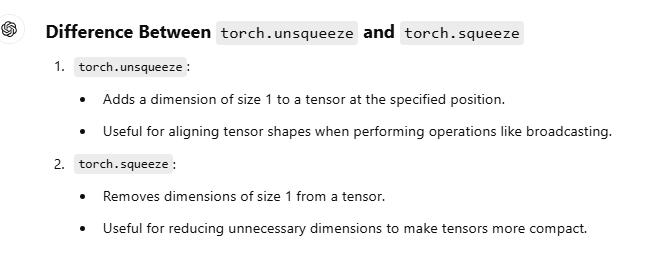

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

In [ ]:
model.eval() #A
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

# note model.eval will makesure the model is in eval mode and will not use the droput
# .train , .eval are two modes which we use them

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

this file has the details about the flops ie floating point operations calculations details https://github.com/rasbt/LLMs-from-scratch/blob/main/ch04/02_performance-analysis/flops-analysis.ipynb

this is really usefull